<a href="https://colab.research.google.com/github/aaanthonyyy/3020-project/blob/master/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import os

# Component Detection

In [30]:
%cd /content/drive/My Drive/3020_drive/Data/Circuits/
%ls


/content/drive/My Drive/3020_drive/Data/Circuits
'20201127_135808 (2).jpg'    IMG-20190503-WA0002.jpg
 circuit-sketch.jpg          IMG-20190503-WA0007-1.jpg
 IMG_20171015_173623.jpg     IMG-20190503-WA0007-2.jpg
 IMG_20171015_173638-1.jpg   IMG-20190503-WA0008-1.jpg


In [31]:
FIG_SIZE = 20
FIG_SIZE = (FIG_SIZE,FIG_SIZE)

# plt.figure(figsize=FIG_SIZE)
# plt.imshow(imgSkel, cmap='gray')

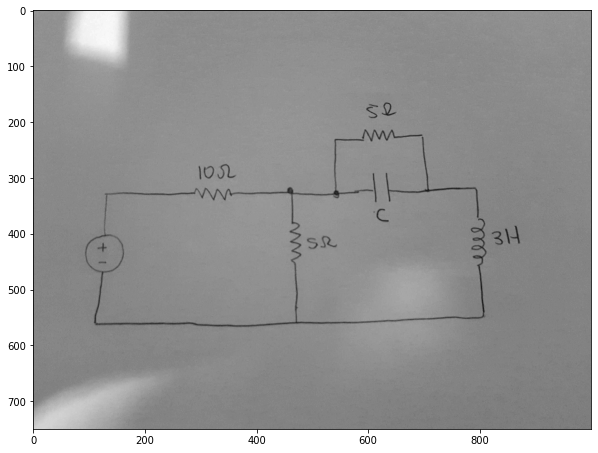

In [32]:
# img_raw = cv2.imread(os.listdir()[7])
img_raw = cv2.imread(os.listdir()[7])
img_raw = cv2.resize(img_raw, (1000, 750), interpolation=4)
img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.show()

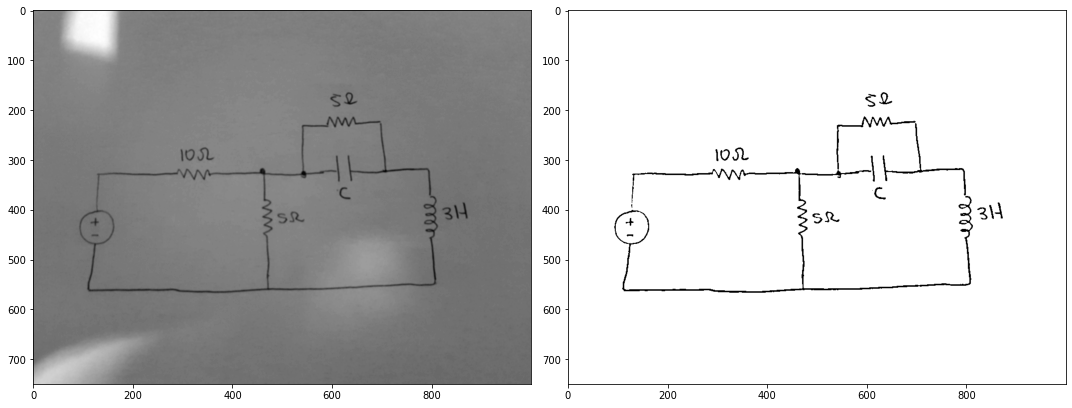

In [33]:
#@title Transformation Parameters { run: "auto" }

BLOCK = 27 #@param {type:"slider", min:1, max:27, step:2}
C = 10 #@param {type:"slider", min:0, max:30, step:1}

img = cv2.GaussianBlur(img,(5,5),0)

imgTres = cv2.adaptiveThreshold(img,255,
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY
                                ,BLOCK,C)

scale = 15

plt.figure(figsize=(1*scale,2*scale))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(imgTres, cmap='gray')

plt.tight_layout()

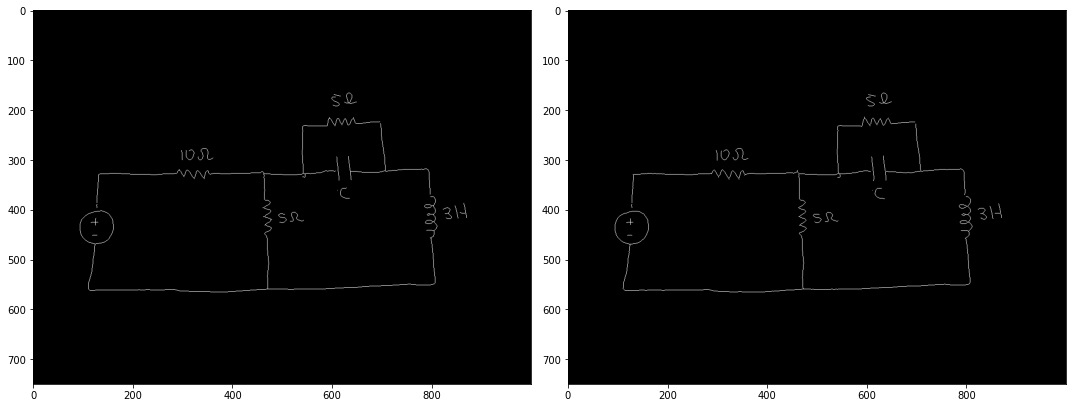

In [34]:
from skimage import io, color, morphology

imgSkel = morphology.skeletonize(imgTres < 0.5)
imgThin = morphology.thin(imgTres < 0.5)

plt.figure(figsize=(1*scale,2*scale))
plt.subplot(1,2,1)
plt.imshow(imgSkel, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(imgThin, cmap='gray')

plt.tight_layout()

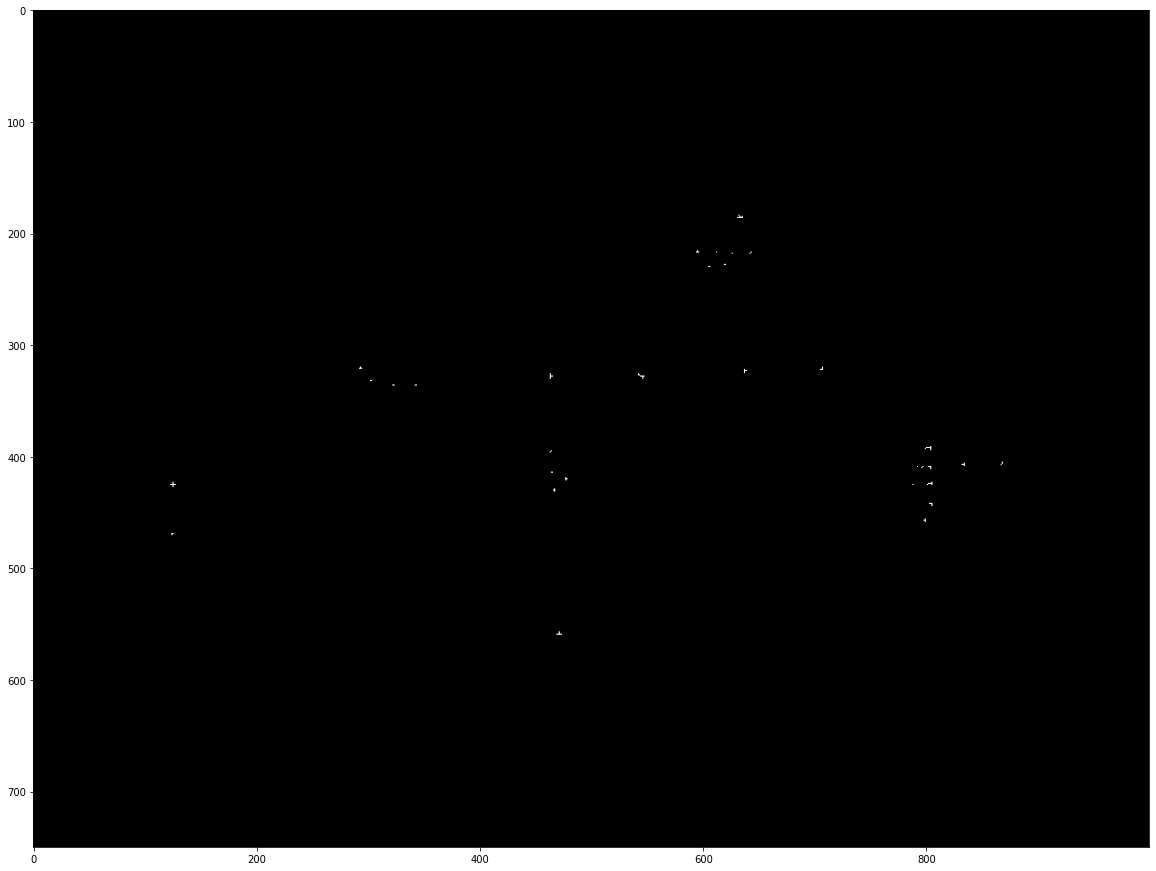

In [35]:
imgSkel.dtype = 'uint8'

# kernel for end and branch points
kernel = np.uint8([[1, 1, 1,  1, 1],
                   [1, 1, 1,  1, 1],
                   [1, 1, 10, 1, 1],
                   [1, 1, 1,  1, 1],
                   [1, 1, 1,  1, 1]])

# conv filer to detect end points
filtered = cv2.filter2D(imgSkel,-1,kernel)

out = np.zeros_like(imgSkel)
out[np.where(filtered > 15)] = 255

# ends   = np.where(filtered == 11)

plt.figure(figsize=FIG_SIZE)
plt.imshow(out, cmap='gray')

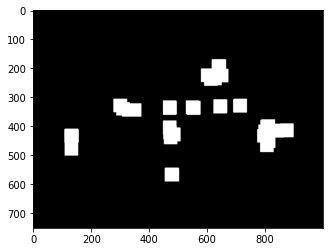

In [36]:
img_dil = np.ones_like(img) * 255
kernel = np.ones((4,4), np.uint8)  

# dilate to generate blobs from endpoint
img_dil = cv2.dilate(out, kernel, iterations=15)  

plt.imshow(img_dil, cmap='gray')

In [37]:
# draw bounding boxes around detection components (blobs)
# returns tuple of new image with boudning boxes, and component locations

def detect_components(img_raw):

    img_cont = img_raw.copy()

    # contour detection
    contours5, heirachy = cv2.findContours(img_dil, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    components = []

    for c in contours5:
        x, y, w, h = cv2.boundingRect(c)

        # threshold for 51x50 bounding box
        if(w > 51 or h > 50):
            # only include if box meets this threshold
            components.append(np.array((y, h, x, w)))

            # rect = cv2.rectangle(img_cont, (x, y), (x + w, y + h), (0,255,0), 3)

    return components

In [50]:

def draw_squares(img_raw):

    img_squares = img_raw.copy()
    components = detect_components(img_squares)
    squares = []

    for i in range(len(components)):
        y,h,x,w = components[i]

        # expanding aspect ratio to square
        if h > w:
            square = (y, y+h, x - h//4, x + 3*h//4) # expand quater on the right,
                                                    # 3/4 on the left of image
        else:
            square = (y - w//4, y + 3*w//4, x, x+w) # expand quater on the bottom,
                                                    # 3/4 on the top of image

        # squares.append(square)
        squares.append(square)
        y,h,x,w = square

        # draw squares on copy of the img_raw
        # cv2.rectangle(img_raw, (x, y), (w, h), (0,255,0), 3)

    return squares

In [39]:
import tensorflow as tf

# deep convolutional neural network
model = tf.keras.models.load_model('/content/drive/MyDrive/3020_drive/Colab Notebooks/Models/10000_20_epocs/')

# return the dict of predictions for the list of components
def predict_objects(img_raw):

    class_names = ['diode', 'resistor', 'inductor', 'capacitor', 'power']
    components = draw_squares(img_raw)

    component_objects = {}

    for i in range(len(components)):
        y,h,x,w = components[i]

        # expanding aspect ratio to square
        crop = img[y:h, x:w]


        x = tf.keras.preprocessing.image.img_to_array(crop)

        try:
            x = cv2.resize(x, (128, 128))
        except:
            continue
        
        x = np.expand_dims(x, axis=0)
        x = np.vstack([x])
        x.shape

        prediction = model.predict(x)

        # output of softmax -> gives class with highest probaility
        classes = np.argmax(prediction, axis=-1)

        # maps highest probability class with classname
        class_prediction = class_names[int(classes)]

        component_objects.update({i + 1 : 
                                    {
                                      'component': class_prediction,
                                      'bounding_box' : components[i]
                                    }
                                  })
                             
    return component_objects

In [40]:
def draw_components(img_raw):

    img = img_raw.copy()

    try:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    except:
        pass

    components = predict_objects(img)

    FONT_FACE = cv2.FONT_HERSHEY_COMPLEX_SMALL
    FONT_SCALE = 0.9
    COLOR = (0,255,0)


    for i in components:
        y,h,x,w = components[i]['bounding_box']

        # draw bounding-boxes around image
        cv2.rectangle(img, (x, y), (w, h), COLOR, 3)

        # get predicted label for component
        component = components[i]['component']

        # add labels above bounding boxes
        cv2.putText(img, component, (x, y-12), FONT_FACE, FONT_SCALE, COLOR)       

    return img

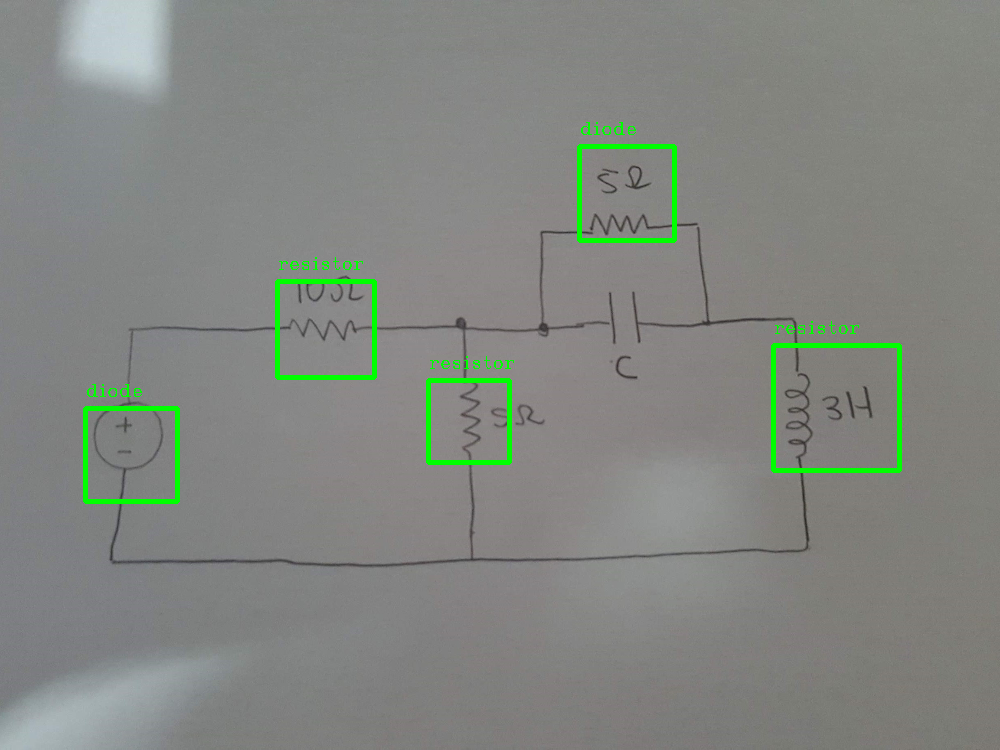

In [52]:
cv2_imshow(draw_components(img_raw))

#### Alternate function

In [53]:
import tensorflow as tf

# deep convolutional neural network
model = tf.keras.models.load_model('/content/drive/MyDrive/3020_drive/Colab Notebooks/Models/10000_20_epocs/')


# return the prediction for the list of components
# 'components' should be a list contaning location and dimension of components
# y, h, x, w

def predict_objects2(components):

    component_objects = {}

    for i in range(len(components)):
        y,h,x,w = components[i]

        # expanding aspect ratio to square
        if h > w:
            crop = img[y:y+h, x - h//4: x + 3*h//4]
        else:
            crop = img[y - w//4: y + 3*w//4, x: x+w]

        class_names = ['diode', 'resistor', 'inductor', 'capacitor', 'power']

        x = tf.keras.preprocessing.image.img_to_array(crop)
        x = cv2.resize(x, (128, 128))
        x = np.expand_dims(x, axis=0)
        x = np.vstack([x])
        x.shape

        prediction = model.predict(x)

        # output of softmax <-> gives class with highest probaility
        classes = np.argmax(prediction, axis=-1)

        # maps highest probability class with classname
        class_prediction = class_names[int(classes)]

        component_objects.update({i + 1 : {'component': class_prediction, 'bounding_box' : components[i]}})
                             
    return component_objects

# Circuit Generation

In [65]:
import pprint
cad_components = predict_objects(imgTres)
pprint.pprint(cad_components)

{1: {'bounding_box': (408, 501, 85, 177), 'component': 'diode'},
 2: {'bounding_box': (380, 462, 428, 509), 'component': 'resistor'},
 3: {'bounding_box': (345, 470, 773, 899), 'component': 'resistor'},
 4: {'bounding_box': (281, 377, 277, 374), 'component': 'resistor'},
 5: {'bounding_box': (146, 240, 579, 674), 'component': 'diode'}}


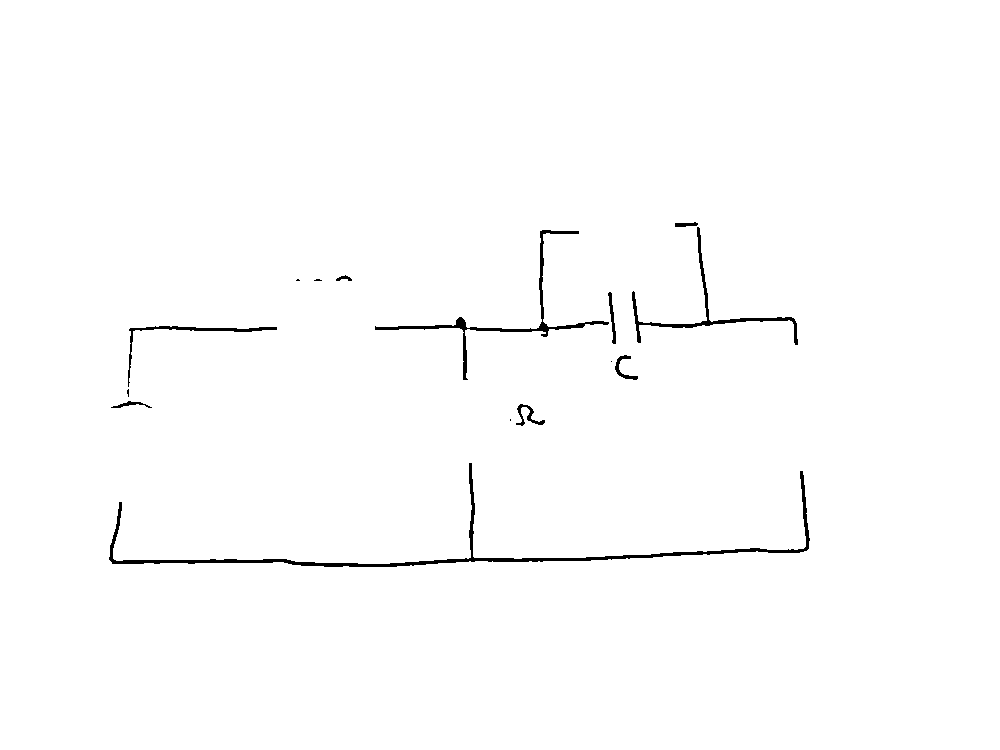

In [66]:
img_nodes = imgTres.copy()

squares = draw_squares(img_nodes)

for square in squares:
    y,h,x,w = square

    cv2.rectangle(img_nodes, (x, y), (w, h), (255,255,255), -1)

# img_nodes = cv2.bilateralFilter(img_nodes,91,75,75)
cv2_imshow(img_nodes)


In [56]:
# copy img_node for horizontal
# and vertical lines
img_horiz = img_nodes.copy()
img_vert = img_nodes.copy()

# Specify size on horizontal axis
horizontal_size = vertical_size = 15

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size,1))

# Apply morphology operations
img_horiz = cv2.dilate(img_horiz, horizontalStructure)
img_horiz = cv2.erode(img_horiz, horizontalStructure)


# Show extracted horizontal lines
# cv2_imshow(img_horiz)


In [57]:
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1,vertical_size))

# Apply morphology operations
img_vert = cv2.dilate(img_vert, verticalStructure)
img_vert = cv2.erode(img_vert, verticalStructure)


# Show extracted vertical lines
# cv2_imshow(img_vert)

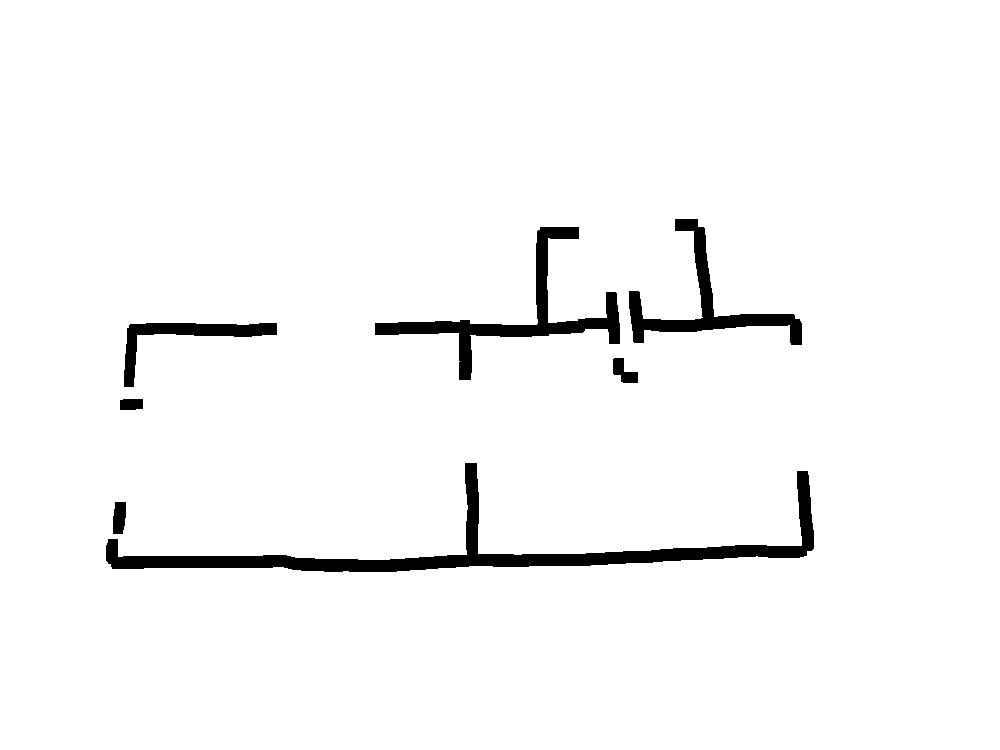

In [58]:
straight_horiz = img_horiz.copy()
straight_vert = img_vert.copy()

# Specify size on horizontal axis
horizontal_size = vertical_size = 10

# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1,horizontal_size))
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (vertical_size,1))


# Apply morphology operations
straight_horiz = cv2.erode(straight_horiz, horizontalStructure)

straight_vert = cv2.erode(straight_vert, verticalStructure)


# combone horizontal and vertical components
straight_lines = cv2.bitwise_and(straight_vert,straight_horiz)

cv2_imshow(straight_lines)

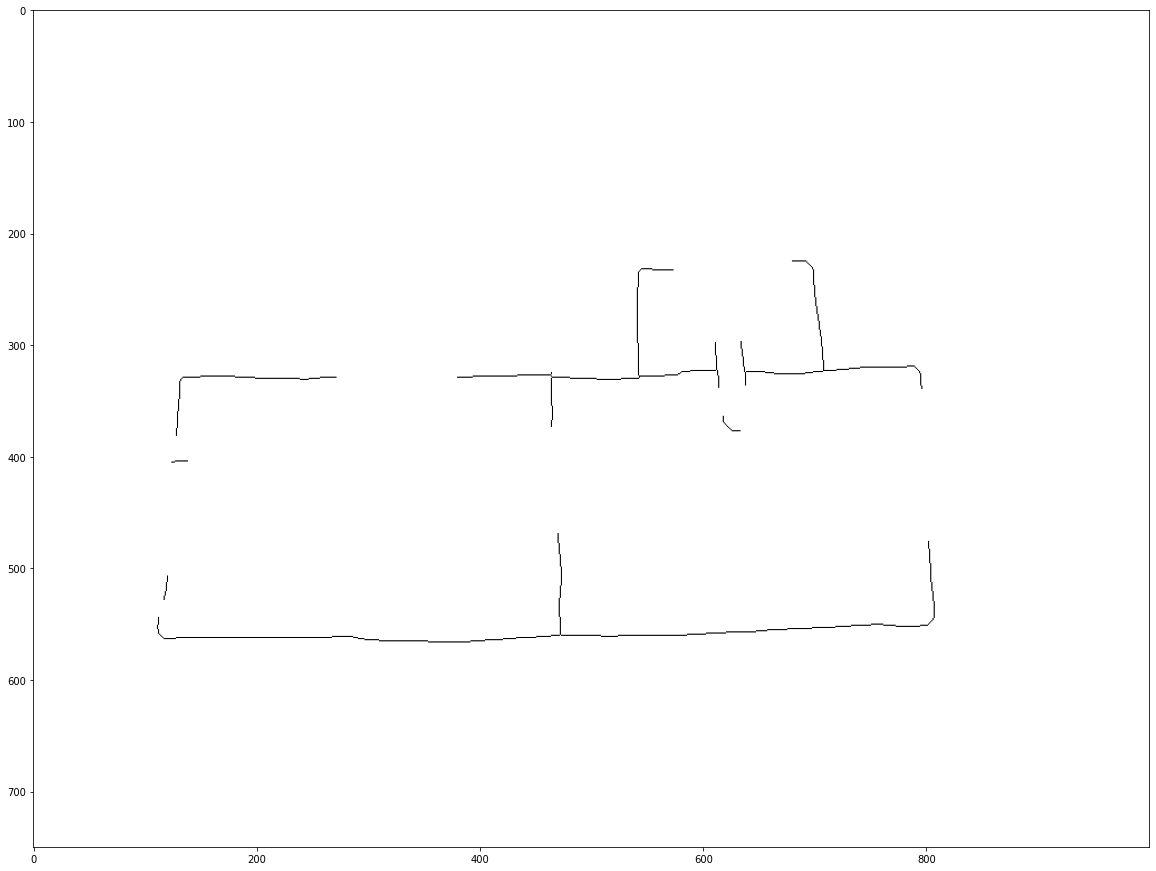

In [59]:
from skimage.morphology import skeletonize

straight_thin = skeletonize(straight_lines < 0.5, method='lee')

plt.figure(figsize=FIG_SIZE)
plt.imshow(straight_thin, cmap="binary")

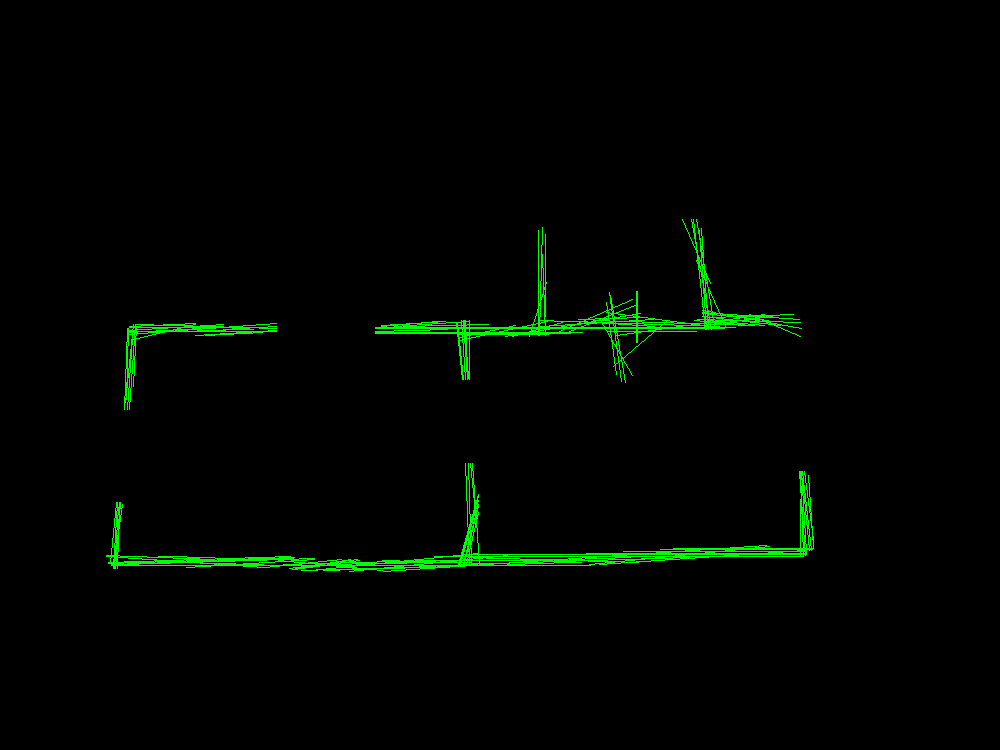

In [60]:
straight_lines = cv2.bitwise_not(straight_lines)

straight_color = cv2.cvtColor(straight_lines, cv2.COLOR_GRAY2BGR)


lines = cv2.HoughLinesP(straight_lines,
                        rho=6,
                        theta = np.pi / 90,
                        threshold = 160,
                        lines=np.array([]),
                        minLineLength=50,
                        maxLineGap=20)

img_blank = np.zeros_like(straight_color)


for line in lines:
    x, y, w, h = line.T
    cv2.line(img_blank,(x,y),(w,h),(0,255,0), 1)
    
cv2_imshow(img_blank)